# Overview

In this tutorial we will explore the building blocks required to create a contracting-expanding convolutional neural network (CNN) to perform kidney segmentation on CT.

This tutorial is part of the class **Introduction to Deep Learning for Medical Imaging** at University of California Irvine (CS190); more information can be found at: https://github.com/peterchang77/dl_tutor/tree/master/cs190.

# Google Colab

The following lines of code will configure your Google Colab environment for this tutorial.

### Enable GPU runtime

Use the following instructions to switch the default Colab instance into a GPU-enabled runtime:

```
Runtime > Change runtime type > Hardware accelerator > GPU
```

# Environment

### Jarvis library

In this notebook we will Jarvis, a custom Python package to facilitate data science and deep learning for healthcare. Among other things, this library will be used for low-level data management, stratification and visualization of high-dimensional medical data.

In [1]:
# --- Install jarvis (only in Google Colab or local runtime)
% pip install jarvis-md

     |████████████████████████████████| 89 kB 8.8 MB/s 
     |████████████████████████████████| 596 kB 69.5 MB/s 
  Attempting uninstall: pyyaml
    Found existing installation: PyYAML 3.13
    Uninstalling PyYAML-3.13:
      Successfully uninstalled PyYAML-3.13


### Imports

Use the following lines to import any additional needed libraries:

In [2]:
import numpy as np, pandas as pd
import tensorflow as tf
from tensorflow.keras import Input, Model, models, layers, losses, metrics, optimizers
from jarvis.train import datasets
from jarvis.utils.display import imshow

# Data

The data used in this tutorial will consist of kidney tumor CT exams derived from the Kidney Tumor Segmentation Challenge (KiTS). More information about he KiTS Challenge can be found here: https://kits21.kits-challenge.org/. In this exercise, we will use this dataset to derive a model for slice-by-slice kidney segmentation. The custom `datasets.download(...)` method can be used to download a local copy of the dataset. By default the dataset will be archived at `/data/raw/ct_kits`; as needed an alternate location may be specified using `datasets.download(name=..., path=...)`. 

In [3]:
# --- Download dataset
datasets.download(name='ct/kits')

[ 2022-05-03 20:08:07 ] [====================] 100.000% : Extracting archive (0000818 / 0000818) 

{'code': '/data/raw/ct_kits', 'data': '/data/raw/ct_kits'}

Once downloaded, the `datasets.prepare(...)` method can be used to generate the required python Generators to iterate through the dataset, as well as a `client` object for any needed advanced functionality. As needed, pass any custom configurations (e.g. batch size, normalization parameters, etc) into the optional `configs` dictionary argument. 

To specificy the correct Generator template file, pass a designated `keyword` string. In this tutorial, we will be using abdominal CT volumes that have been preprocessed into 96 x 96 x 96 matrix volumes, each cropped to the right and left kidney, facilitating ease of algorithm training within the Google Colab platform. To select the correct Client template for this task, use the keyword string `2d-bin`. 

In [4]:
# --- Prepare generators
gen_train, gen_valid, client = datasets.prepare(name='ct/kits', keyword='2d-bin', custom_layers=True)

The created generators yield a total of `batch['size']` training samples based on the specified batch size. As before, each iteration yields dictionary of model inputs, `xs`. In the current example, there is just a single input image `xs['dat']` and a single target `xs['lbl']`. Let us examine the generator data:

In [5]:
# --- Yield one example
xs, _ = next(gen_train)

# --- Print dict keys
for k, v in xs.items():
    print('key = {} : shape = {}'.format(k.ljust(7), v.shape))

key = dat     : shape = (16, 1, 96, 96, 1)
key = lbl     : shape = (16, 1, 96, 96, 1)


### KITS Data

The input images in the variable `dat` are matrices of shape `1 x 96 x 96 x 1`. Note that even though the images here are 2D in shape, the full matrix is a 3D tensor `(z, y, x)` where `z = 1` in this implementation. Note that although the 3rd z-axis dimension is redundant here (for a single slice input), many of our more complex models and architectures will commonly require a full 3D tensor. Because of this, we will directly use 3D convolutions throughout the tutorial materials for consistency.

Use the following lines of code to visualize using the `imshow(...)` method:

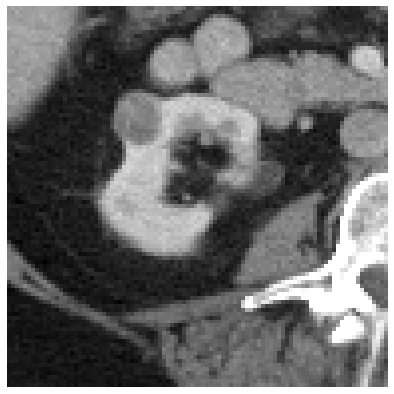

In [6]:
# --- Show the first example
imshow(xs['dat'][0])

Use the `montage(...)` function to create an N x N mosaic of all images:

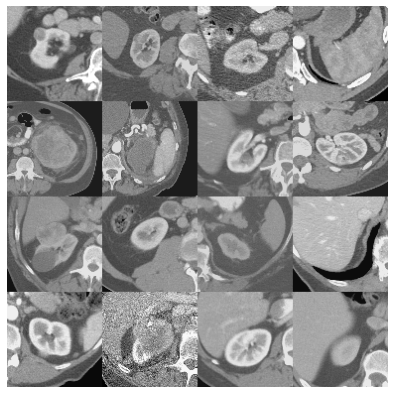

In [7]:
# --- Show "montage" of all images
imshow(xs['dat'])

### Kidney masks

The ground-truth labels are binary masks of the same matrix shape as the model input:

In [8]:
print(xs['lbl'][0].shape)

(1, 96, 96, 1)


Use the `imshow(...)` method to visualize the ground-truth tumor mask labels:

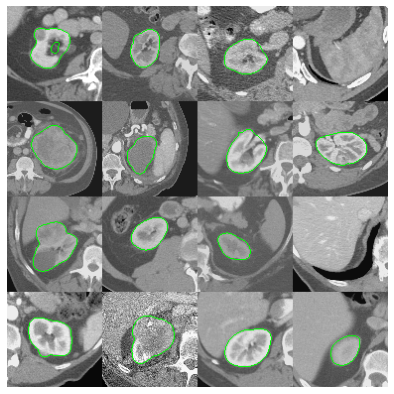

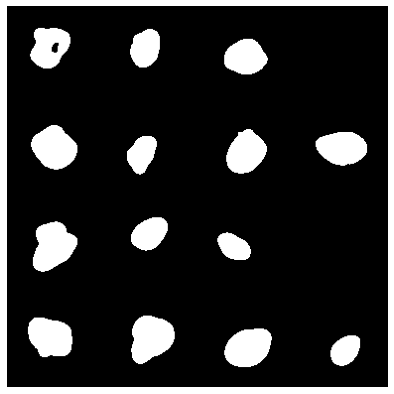

In [9]:
# --- Show tumor masks overlaid on original data
imshow(xs['dat'], xs['lbl'])

# --- Show tumor masks isolated
imshow(xs['lbl'])

# Contracting Layers

As discussed in lecture, the contracting layers of a U-Net architecture are essentially identical to a standard feed-forward CNN. In addition, several key modifications to the original architecture will be made in ths implementation including:

* same padding (vs. valid padding)
* strided convoltions (vs. max-pooling)
* smaller filters (channel depths)

Let us start by defining the contracting layer architecture below. 

In [10]:
# --- Define kwargs dictionary
kwargs = {
    'kernel_size': (1, 3, 3),
    'padding': 'same'}

# --- Define lambda functions
conv = lambda x, filters, strides : layers.Conv3D(filters=filters, strides=strides, **kwargs)(x)
norm = lambda x : layers.BatchNormalization()(x)
relu = lambda x : layers.ReLU()(x)

# --- Define stride-1, stride-2 blocks
conv1 = lambda filters, x : relu(norm(conv(x, filters, strides=1)))
conv2 = lambda filters, x : relu(norm(conv(x, filters, strides=(1, 2, 2))))

Using these lambda functions, let us define a simple 9-layer contracting network topology with a total a four subsample (stride-2 convolution) operations:

In [11]:
# --- Define model input 
x = Input(shape=(None, 96, 96, 1), dtype='float32')

# --- Define contracting layers
l1 = conv1(8, x)
l2 = conv1(16, conv2(16, l1))
l3 = conv1(32, conv2(32, l2))
l4 = conv1(48, conv2(48, l3))
l5 = conv1(64, conv2(64, l4))

In [12]:
l1

<KerasTensor: shape=(None, None, 96, 96, 8) dtype=float32 (created by layer 're_lu')>

In [13]:
l5

<KerasTensor: shape=(None, None, 6, 6, 64) dtype=float32 (created by layer 're_lu_8')>

What is the shape of the `l5` feature map?

# Expanding Layers

As discussed in lecture, the expanding layers are simply implemented by reversing the operations found in the contract layers above. Specifically, each subsample operation is now replaced by a **convolutional transpose**. Due to the use of **same** padding, defining a transpose operation with the exact same parameters as a strided convolution will ensure that layers in the expanding pathway will exactly match the shape of the corresponding contracting layer.

### Convolutional transpose

Let us start by defining an additional lambda function for the convolutional transpose:

In [14]:
# --- Define single transpose
tran = lambda x, filters, strides : layers.Conv3DTranspose(filters=filters, strides=strides, **kwargs)(x)

# --- Define transpose block
tran2 = lambda filters, x : relu(norm(tran(x, filters, strides=(1, 2, 2))))

Carefully compare these functions to the single `conv` operations as well as the `conv1` and `conv2` blocks above. Notice that they share the exact same configurations.

Let us now apply the first convolutional transpose block to the `l5` feature map:

In [15]:
# --- Define expanding layers
l6 = tran2(48, l5)

What is the shape of the `l6` feature map?

In [16]:
l6.shape

TensorShape([None, None, 12, 12, 48])

### Concatenation

The first connection in this specific U-Net derived architecture is a link between the `l4` and the `l6` layers:

```
l1 -------------------> l9
  \                    /
   l2 -------------> l8
     \              /   
      l3 -------> l7
        \        /
         l4 -> l6
           \  /
            l5
```

To mediate the first connection between contracting and expanding layers, we must ensure that `l4` and `l6` match in feature map size (the number of filters / channel depth *do not* necessarily). Using the `same` padding as above should ensure that this is the case and thus simplifies the connection operation:

In [17]:
# --- Ensure shapes match
print(l4.shape)
print(l6.shape)

# --- Concatenate
concat = lambda a, b : layers.Concatenate()([a, b])
concat(l4, l6)

(None, None, 12, 12, 48)
(None, None, 12, 12, 48)


<KerasTensor: shape=(None, None, 12, 12, 96) dtype=float32 (created by layer 'concatenate')>

Note that since `l4` and `l6` are **exactly the same shape** (including matching channel depth), what additional operation could be used here instead of a concatenation?

### Full expansion

Alternate the use of `conv1` and `tran2` blocks to build the remainder of the expanding pathway:

In [18]:
# --- Define expanding layers
l7  = tran2(32, conv1(48, concat(l4, l6)))
l8  = tran2(16, conv1(32, concat(l3, l7)))
l9  = tran2(8,  conv1(16, concat(l2, l8)))
l10 = conv1(8,  l9)

# Logits

The last convolution projects the `l10` feature map into a total of just `n` feature maps, one for each possible class prediction. In this 2-class prediction task, a total of `2` feature maps will be needed. Recall that these feature maps essentially act as a set of **logit scores** for each voxel location throughout the image.

As in all prior exercises, **do not** use an activation here in the final convolution:

In [19]:
# --- Create logits
logits = layers.Conv3D(filters=2, **kwargs)(l10)

Now let us create the `backbone` model:

In [20]:
# --- Create model
backbone = Model(inputs=x, outputs=logits)

# Training model

Next, the `backbone` model architecture is wrapped in a second model with additional layer(s) that define optimization behavior including loss function derivations.

### Inputs

As before, we start by defining all `inputs` into our new *wrapper* model.

In [21]:
inputs = {
    'dat': Input(shape=(None, 96, 96, 1), name='dat'),
    'lbl': Input(shape=(None, 96, 96, 1), name='lbl')}

Using this `inputs` Python dictionary, let us first recreate the CNN model operations by **reusing** the `backbone` object that we already defined. Doing so means that our new *wrapper* model is explicitly derived from the `backbone`. Any updates applied to our new *wrapper* model are propogated to the `backbone` model and vice versa. 

In [22]:
# --- Define first step of new wrapper model
logits = backbone(inputs['dat'])

### Cross-entroy loss

There are multiple loss functions that may be used for segmentation tasks. In the current tutorial, we are predicting a class label for each voxel (3D pixel) in the original image. This objective may be formulated as a voxel-by-voxel softmax cross-entropy loss. 

To define a softmax cross-entropy loss in Tensorflow, use the `losses.SparseCategoricalCrossentropy(...)` class:

In [23]:
# --- Define loss object
sce = losses.SparseCategoricalCrossentropy(from_logits=True)

# --- Create loss tensor
loss = sce(y_true=inputs['lbl'], y_pred=logits)

 ### Dice score metric
 
While percent accuracy may be used to print the per voxel performance accuracy, recall that the majority of voxels contain background, and thus it is possible for the algorithm to be > 99% accurate while still missing the majority of relevant foreground regions. Instead, to calculate accuracy for segmentation tasks, we use a metric for spatial overlap known as the **Dice score**. The Dice score is not a default metric built in the Tensorflow library, and thus we will define it here.

In [24]:
def calculate_dsc(y_true, y_pred, c=1):
    """
    Method to calculate the Dice score coefficient for given class
    
    :params
    
      y_true : ground-truth label
      y_pred : predicted logits scores
           c : class to calculate DSC on
    
    """    
    true = y_true[..., 0] == c
    pred = tf.math.argmax(y_pred, axis=-1) == c 

    A = tf.math.count_nonzero(true & pred) * 2
    B = tf.math.count_nonzero(true) + tf.math.count_nonzero(pred)
    
    return tf.math.divide_no_nan(
        tf.cast(A, tf.float32), 
        tf.cast(B, tf.float32))

In [25]:
# --- Define Dice score
dsc = calculate_dsc(y_true=inputs['lbl'], y_pred=logits)

### Create model

Now let us create the new wrapper model. The inputs are defined above already in our `inputs` Python dictionary. As outputs, let us return both the `logits` tensor as well as the `loss`. We will name this new wrapper model `training` because it will be used for training only. 

In [26]:
training = Model(inputs=inputs, outputs={'logits': logits, 'loss': loss, 'dsc': dsc})

Now let's add the `loss` and `metric` tensorws we defined above to the new `training` model:

In [27]:
# --- Add loss
training.add_loss(loss)

# --- Add metric
training.add_metric(dsc, name='dsc')

### Compile model

 To prepare the model for learning, a graph must be **compiled** with a strategy for optimization.

In [28]:
# --- Define an Adam optimizer
optimizer = optimizers.Adam(learning_rate=2e-4)

# --- Compile model
training.compile(optimizer=optimizer)

### In-memory data

For moderate sized datasets which are too large to fit into immediate hard-drive cache, but small enough to fit into RAM memory, it is often times a good idea to first load all training data into RAM memory for increased speed of training. The `client` can be used for this purpose as follows:

In [29]:
# --- Load data into memory for faster training
client.load_data_in_memory()

[ 2022-05-03 20:17:41 ] [====================] 100.000% : Iterating | 000402    

Now, let us train the model:

In [30]:
# --- Train model
training.fit(
    x=gen_train, 
    steps_per_epoch=100, 
    epochs=10,
    validation_data=gen_valid,
    validation_steps=100,
    validation_freq=5)

Epoch 1/10
100/100 [==============================] - 15s 25ms/step - loss: 0.4084 - dsc: 0.3039
Epoch 2/10
100/100 [==============================] - 3s 26ms/step - loss: 0.1738 - dsc: 0.7682
Epoch 3/10
100/100 [==============================] - 2s 25ms/step - loss: 0.0979 - dsc: 0.8834
Epoch 4/10
100/100 [==============================] - 3s 26ms/step - loss: 0.0705 - dsc: 0.9038
Epoch 5/10
100/100 [==============================] - 5s 49ms/step - loss: 0.0547 - dsc: 0.9216 - val_loss: 0.0585 - val_dsc: 0.9058
Epoch 6/10
100/100 [==============================] - 3s 25ms/step - loss: 0.0467 - dsc: 0.9289
Epoch 7/10
100/100 [==============================] - 2s 25ms/step - loss: 0.0397 - dsc: 0.9383
Epoch 8/10
100/100 [==============================] - 2s 24ms/step - loss: 0.0354 - dsc: 0.9420
Epoch 9/10
100/100 [==============================] - 2s 24ms/step - loss: 0.0316 - dsc: 0.9485
Epoch 10/10
100/100 [==============================] - 4s 43ms/step - loss: 0.0304 - dsc: 0.9466 -

# Evaluation

To test the trained model, the following steps are required:

* load data
* use `model.predict(...)` to obtain logit scores
* compare prediction with ground-truth
* serialize in Pandas DataFrame

Recall that the generator used to train the model simply iterates through the dataset randomly. For model evaluation, the cohort must instead be loaded manually in an orderly way. For this tutorial, we will create new **test mode** data generators, which will simply load each example individually once for testing. 

In [31]:
# --- Create validation generator
test_train, test_valid = client.create_generators(test=True, expand=True)

**Important note**: although the model is trained using 2D slices, there is nothing to preclude passing an entire 3D volume through the model at one time (e.g. consider that the entire 3D volume is a single *batch* of data). In fact, typically performance metrics for medical imaging models are commonly reported on a volume-by-volume basis (not slice-by-slice). Thus, use the `expand=True` flag in `client.create_generators(...)` as above to yield entire 3D volumes instead of slices.

In [32]:
# --- Run entire volume through model
x, _ = next(test_train)
outputs = training.predict(x)

[ 2022-05-03 20:20:34 ] [>...................] 0.312% : Iterating | 000001      

Use the following lines of code to run prediction through the **valid** cohort generator.

In [33]:
# --- Create validation generator
test_train, test_valid = client.create_generators(test=True, expand=True)

dsc = []

for x, _ in test_valid:
    
    # --- Predict
    outputs = training.predict(x)

    # --- Argmax
    dsc.append(outputs['dsc'])

dsc = np.array(dsc)

[ 2022-05-03 20:20:52 ] [====================] 100.000% : Iterating | 000081    

Prepare results in Pandas DataFrame for ease of analysis and sharing:

In [34]:
# --- Define columns
df = pd.DataFrame(index=np.arange(dsc.size))
df['Dice score'] = dsc

# --- Print accuracy
print(df['Dice score'].mean())

0.9278912993124974


## Saving and Loading a Model

After a model has been successfully trained, it can be saved and/or loaded by simply using the `backbone.save()` and `backbone.load_model()` methods. 

In [35]:
# --- Serialize a model
backbone.save('./tutorial_model.hdf5')

In [36]:
# --- Load a serialized model
del backbone
backbone = models.load_model('./tutorial_model.hdf5', compile=False)